## Import Data and EDA

In [156]:
#Import initial packages
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_context('notebook')
import matplotlib.pyplot as plt
%matplotlib inline
data = pd.read_csv('ATM_training.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 7 columns):
Shops       22000 non-null float64
ATMs        22000 non-null int64
Downtown    22000 non-null int64
Weekday     22000 non-null int64
Center      22000 non-null int64
High        22000 non-null int64
Withdraw    22000 non-null float64
dtypes: float64(2), int64(5)
memory usage: 1.2 MB


In [157]:
#Get numerical idea of data distribution
data.describe()

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
count,22000.000000,22000.000000,22000.00000,22000.000000,22000.000000,22000.000000,22000.000000
mean,7.316373,7.937455,0.70200,0.714091,0.102455,0.301591,54.652818
std,4.118692,3.673415,0.45739,0.451857,0.303252,0.458959,25.099767
min,0.800000,0.000000,0.00000,0.000000,0.000000,0.000000,11.668197
25%,1.050000,4.000000,0.00000,0.000000,0.000000,0.000000,18.500386
50%,9.890000,9.000000,1.00000,1.000000,0.000000,0.000000,68.240749
75%,10.070000,11.000000,1.00000,1.000000,0.000000,1.000000,71.345778
max,10.830000,17.000000,1.00000,1.000000,1.000000,1.000000,103.964065


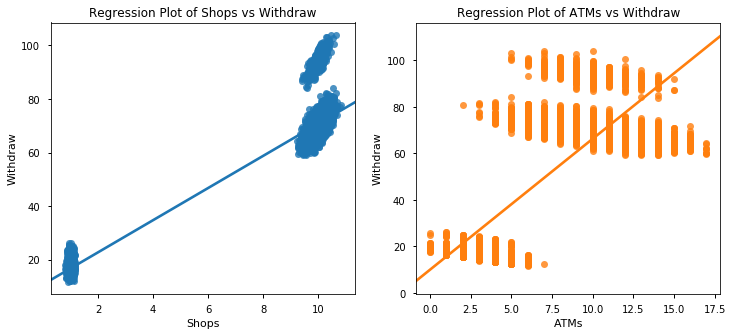

In [158]:
#Regression plots of Shops and ATMs. Note huge gap in number of Stores and interesting trend in ATMs
covariates = ['Shops','ATMs','Downtown','Weekday','Center','High']
fig, ax = plt.subplots(1,2,figsize = (12,5))
sns.regplot(data['Shops'], data['Withdraw'],ax=ax[0])
ax[0].set_title('Regression Plot of Shops vs Withdraw')
sns.regplot(data['ATMs'],data['Withdraw'],ax=ax[1])
ax[1].set_title('Regression Plot of ATMs vs Withdraw')
fig.savefig('regplots.png',bbox_inches='tight')

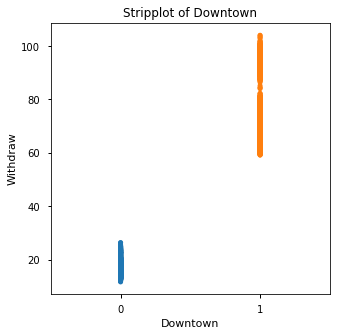

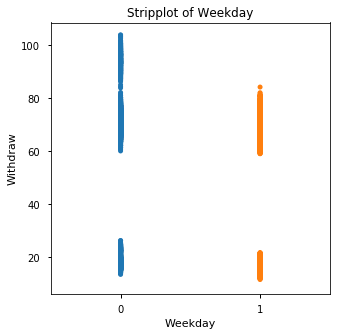

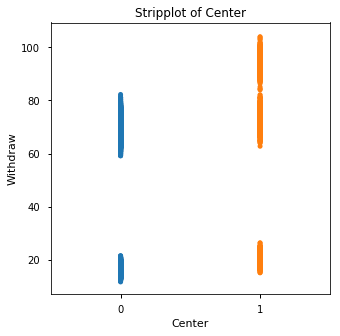

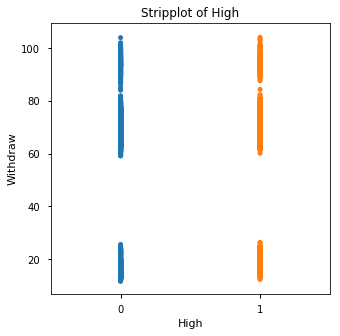

In [159]:
#Stripplots of binary variables
binary = ['Downtown','Weekday','Center','High']
for var in binary:
    fig, ax = plt.subplots(figsize=(5,5))
    sns.stripplot(data[var], data['Withdraw'],ax=ax)
    ax.set_title('Stripplot of {}'.format(var))
    plt.show()

In [160]:
#Proportion breakdown of binaries
binary = ['Downtown','Weekday','Center','High']
for i in binary:
    print('Proportion {}'.format(i), len(data[data[i]==1])/len(data))
    print('Proportion not {}'.format(i), len(data[data[i]==0])/len(data))

Proportion Downtown 0.702
Proportion not Downtown 0.298
Proportion Weekday 0.7140909090909091
Proportion not Weekday 0.2859090909090909
Proportion Center 0.10245454545454545
Proportion not Center 0.8975454545454545
Proportion High 0.3015909090909091
Proportion not High 0.6984090909090909


In [161]:
#Calculate correlations. Note especially high correlation between Downtown and Shops
data.corr().round(3)

,Shops,ATMs,Downtown,Weekday,Center,High,Withdraw
Shops,1.000,0.873,0.999,0.013,0.000,0.002,0.986
ATMs,0.873,1.000,0.874,0.010,-0.003,-0.003,0.824
Downtown,0.999,0.874,1.000,0.013,-0.000,0.002,0.984
Weekday,0.013,0.010,0.013,1.000,-0.007,-0.007,-0.050
Center,0.000,-0.003,-0.000,-0.007,1.000,0.011,0.088
High,0.002,-0.003,0.002,-0.007,0.011,1.000,0.021
Withdraw,0.986,0.824,0.984,-0.050,0.088,0.021,1.000


In [162]:
#No ATMs with less than 200 nearby stores/restaurants that is also downtown
len(data[(data['Shops']<2)&(data['Downtown']==1)])

0

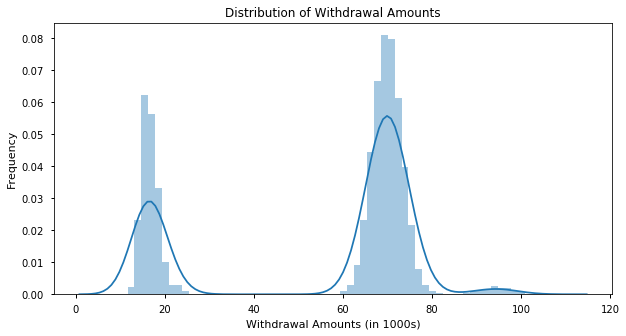

In [163]:
#Distribution of response
fig, ax = plt.subplots(figsize = (10,5))
sns.distplot(data['Withdraw'], ax = ax, bins = 60)
ax.set_title('Distribution of Withdrawal Amounts')
ax.set_ylabel('Frequency')
ax.set_xlabel('Withdrawal Amounts (in 1000s)')

## Train/Test Split

In [169]:
#Training/Validation Split
# Import `train_test_split` from `sklearn.model_selection`
from sklearn.model_selection import train_test_split

# Specify the data 
X=data.ix[:,0:6]

# Specify the target labels and flatten the array 
import numpy as np
y=np.ravel(data.Withdraw)

# Split the data up in train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [166]:
#This data used for final model only
X_train_final = X_train.copy()

## Models

#### Linear Regression (Base)

In [116]:
#Create interactions as per EDA
X_train['ATMs_Center'] = X_train['ATMs']*X_train['Center']
X_train['Weekday_Center'] = X_train['Weekday']*X_train['Center']
X_test['ATMs_Center'] = X_test['ATMs']*X_test['Center']
X_test['Weekday_Center'] = X_test['Weekday']*X_test['Center']

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

#Three OLS models
pred_lg1 = ['Shops','ATMs','Weekday','Center','High','ATMs_Center','Weekday_Center']
pred_lg2 = ['Shops','ATMs','Downtown','Weekday','Center','High','ATMs_Center','Weekday_Center']
pred_lg3 = ['Shops','ATMs','Downtown','Weekday','Center','High']

ols1 = LinearRegression()
ols2 = LinearRegression()
ols3 = LinearRegression()

ols1.fit(X_train[pred_lg1],y_train)
score1 = cross_val_score(ols1, X_train[pred_lg1], y_train, cv = 10, scoring = 'neg_mean_squared_error')
cv_mse1 = -1*np.mean(score1)
pred_ols1 = ols1.predict(X_test[pred_lg1])
test_mse_ols1 = mean_squared_error(pred_ols1, y_test)
print('CV MSE OLS 1:', cv_mse1)
print('Test MSE OLS 1:', test_mse_ols1)
print('----------------------------')

ols2.fit(X_train[pred_lg2],y_train)
score2 = cross_val_score(ols2, X_train[pred_lg2], y_train, cv = 10, scoring = 'neg_mean_squared_error')
cv_mse2 = -1*np.mean(score2)
pred_ols2 = ols2.predict(X_test[pred_lg2])
test_mse_ols2 = mean_squared_error(pred_ols2, y_test)
print('CV MSE OLS 2:', cv_mse2)
print('Test MSE OLS 2:', test_mse_ols2)
print('----------------------------')

ols3.fit(X_train[pred_lg3],y_train)
score3 = cross_val_score(ols3, X_train[pred_lg3], y_train, cv = 10, scoring = 'neg_mean_squared_error')
cv_mse3 = -1*np.mean(score3)
pred_ols3 = ols3.predict(X_test[pred_lg3])
test_mse_ols3 = mean_squared_error(pred_ols3, y_test)
print('CV MSE OLS 3:', cv_mse3)
print('Test MSE OLS 3:', test_mse_ols3)

CV MSE OLS 1: 2.42755181526
Test MSE OLS 1: 2.34044650691
----------------------------
CV MSE OLS 2: 1.96518321355
Test MSE OLS 2: 1.83196673049
----------------------------
CV MSE OLS 3: 6.43077361389
Test MSE OLS 3: 5.88040670435


#### Polynomial Features with Forward Selection

For p=1, min average MSE=6.4454. alpha=0.0
For p=2, min average MSE=1.5932. alpha=0.0
For p=3, min average MSE=0.2618. alpha=0.0
For p=4, min average MSE=0.2699. alpha=0.0


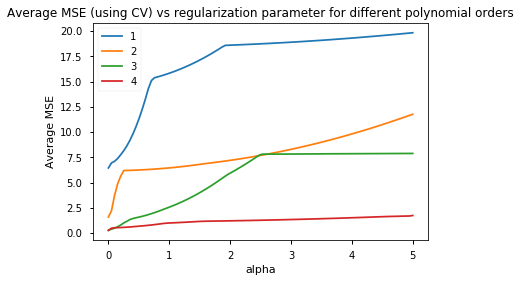

In [26]:
#Cross validation for best polynomal order. Best order is 3. Note alpha is 0, so Lasso isn't doing any regularization
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
x = ['Shops','ATMs','Downtown','Weekday','Center','High']

for p in range(1, 5, 1):
    X_poly = PolynomialFeatures(p).fit_transform(X_train[x])
    model = LassoCV(cv=10, alphas=np.linspace(0, 5, 100))
    model.fit(X_poly, y_train)
    plt.plot(model.alphas_, model.mse_path_.mean(axis=-1), label=str(p))
    print('For p={}, min average MSE={}. alpha={}'.format(p, np.round(np.min(model.mse_path_.mean(axis=-1)), 4), np.round(model.alpha_, 4)))
    
plt.xlabel('alpha'); plt.ylabel('Average MSE'); plt.legend()
plt.title('Average MSE (using CV) vs regularization parameter for different polynomial orders')

In [31]:
#Create frame of all interactions up to order 3
X_poly = pd.DataFrame(PolynomialFeatures(3).fit_transform(X_train[x]))

In [41]:
#Forward selection on X_poly. This code is used from QBUS 2820 with Dr. Marcel Scharth
def forwardselection(X, y):

    # Functions
    from sklearn.linear_model import LinearRegression
    from sklearn.model_selection import cross_val_score

    # Initialisation
    base = []
    p = X.shape[1]
    candidates = list(np.arange(p))

    # Forward recursion
    i=1
    bestcvscore=-np.inf    
    while i<=p:
        bestscore = 0
        for variable in candidates:
            ols = LinearRegression()
            ols.fit(X.iloc[:, base + [variable]], y)
            score = ols.score(X.iloc[:, base + [variable]], y)
            if score > bestscore:
                bestscore = score 
                best = ols
                newvariable=variable
        base.append(newvariable)
        candidates.remove(newvariable)
        
        cvscore = cross_val_score(best, X.iloc[:, base], y, scoring='neg_mean_squared_error').mean() 
        
        if cvscore > bestcvscore:
            bestcvscore=cvscore
            bestcv = best
            subset = base[:]
        i+=1
    
    #Finalise
    return bestcv, subset


class forward:
    def __init__(self):
        pass

    def fit(self, X, y):
        self.ols, self.subset = forwardselection(X, y)

    def predict(self, X):
        return self.ols.predict(X.iloc[:, self.subset])

    def cv_score(self, X, y, cv=10):
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(self.ols, X.iloc[:, self.subset], np.ravel(y), cv=cv, scoring='neg_mean_squared_error')
        return np.sqrt(-1*np.mean(scores))

In [42]:
forwardselection(X_poly,y_train)

(LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),
 [7, 11, 69, 2, 4, 6, 32, 28, 23, 5, 44, 30, 15, 36, 55, 53, 38, 59, 57])

In [45]:
#To get names of features
X_polynames = PolynomialFeatures(3).fit(X_train[x])
X_polynames.get_feature_names(data.columns)

['1',
 'Shops',
 'ATMs',
 'Downtown',
 'Weekday',
 'Center',
 'High',
 'Shops^2',
 'Shops ATMs',
 'Shops Downtown',
 'Shops Weekday',
 'Shops Center',
 'Shops High',
 'ATMs^2',
 'ATMs Downtown',
 'ATMs Weekday',
 'ATMs Center',
 'ATMs High',
 'Downtown^2',
 'Downtown Weekday',
 'Downtown Center',
 'Downtown High',
 'Weekday^2',
 'Weekday Center',
 'Weekday High',
 'Center^2',
 'Center High',
 'High^2',
 'Shops^3',
 'Shops^2 ATMs',
 'Shops^2 Downtown',
 'Shops^2 Weekday',
 'Shops^2 Center',
 'Shops^2 High',
 'Shops ATMs^2',
 'Shops ATMs Downtown',
 'Shops ATMs Weekday',
 'Shops ATMs Center',
 'Shops ATMs High',
 'Shops Downtown^2',
 'Shops Downtown Weekday',
 'Shops Downtown Center',
 'Shops Downtown High',
 'Shops Weekday^2',
 'Shops Weekday Center',
 'Shops Weekday High',
 'Shops Center^2',
 'Shops Center High',
 'Shops High^2',
 'ATMs^3',
 'ATMs^2 Downtown',
 'ATMs^2 Weekday',
 'ATMs^2 Center',
 'ATMs^2 High',
 'ATMs Downtown^2',
 'ATMs Downtown Weekday',
 'ATMs Downtown Center',
 'A

In [117]:
#Interactions created from Forward Selection
X_train['Shops_2'] = X_train['Shops']*X_train['Shops']
X_train['Shops_Center'] = X_train['Shops']*X_train['Center']
X_train['Downtown_Weekday'] = X_train['Downtown']*X_train['Weekday']
X_train['Shops_2_Center'] = X_train['Shops_2']*X_train['Center']
X_train['Shops_3'] = X_train['Shops']*X_train['Shops_2']
X_train['Shops_ATMs_Downtown'] = X_train['Shops']*X_train['ATMs']*X_train['Downtown']
X_train['Shops_Weekday_Center'] = X_train['Shops_Center']*X_train['Weekday']
X_train['ATMs_High'] = X_train['ATMs']*X_train['High']
X_train['Shops_Downtown_High'] = X_train['Shops']*X_train['Downtown']*X_train['High']
X_train['ATMs_2_Weekday'] = X_train['ATMs']*X_train['ATMs']*X_train['Weekday']
X_train['Shops_ATMs_High'] = X_train['Shops']*X_train['ATMs_High']
X_train['Shops_High'] = X_train['Shops']*X_train['High']

In [118]:
X_test['Shops_2'] = X_test['Shops']*X_test['Shops']
X_test['Shops_Center'] = X_test['Shops']*X_test['Center']
X_test['Downtown_Weekday'] = X_test['Downtown']*X_test['Weekday']
X_test['Shops_2_Center'] = X_test['Shops_2']*X_test['Center']
X_test['Shops_3'] = X_test['Shops']*X_test['Shops_2']
X_test['Shops_ATMs_Downtown'] = X_test['Shops']*X_test['ATMs']*X_test['Downtown']
X_test['Shops_Weekday_Center'] = X_test['Shops_Center']*X_test['Weekday']
X_test['ATMs_High'] = X_test['ATMs']*X_test['High']
X_test['Shops_Downtown_High'] = X_test['Shops']*X_test['Downtown']*X_test['High']
X_test['ATMs_2_Weekday'] = X_test['ATMs']*X_test['ATMs']*X_test['Weekday']
X_test['Shops_ATMs_High'] = X_test['Shops']*X_test['ATMs_High']
X_test['Shops_High'] = X_test['Shops']*X_test['High']

In [48]:
X_train.head()

,Shops,ATMs,Downtown,Weekday,Center,High,ATMs_Center,Center_Weekday,Weekday_Center,Shops_2,...,Downtown_Weekday,Shops_2_Center,Shops_3,Shops_ATMs_Downtown,Shops_Weekday_Center,ATMs_High,Shops_Downtown_High,ATMs_2_Weekday,Shops_ATMs_High,Shops_High
4900,9.66,10,1,1,0,0,0,0,0,93.3156,...,1,0.0,901.428696,96.60,0.0,0,0.00,100,0.00,0.00
20025,10.27,7,1,0,0,1,0,0,0,105.4729,...,0,0.0,1083.206683,71.89,0.0,7,10.27,0,71.89,10.27
1929,1.00,3,0,1,0,0,0,0,0,1.0000,...,0,0.0,1.000000,0.00,0.0,0,0.00,9,0.00,0.00
4901,9.83,9,1,1,0,0,0,0,0,96.6289,...,1,0.0,949.862087,88.47,0.0,0,0.00,81,0.00,0.00
9750,10.14,11,1,1,0,0,0,0,0,102.8196,...,1,0.0,1042.590744,111.54,0.0,0,0.00,121,0.00,0.00


In [119]:
x_int = ['Shops','ATMs','Weekday','Downtown','Center','High','Shops_2','Shops_Center','Downtown_Weekday',
         'Shops_2_Center','Shops_3','Weekday_Center','Shops_ATMs_Downtown','Shops_Weekday_Center',
         'ATMs_High','Shops_Downtown_High','ATMs_Center','ATMs_2_Weekday','Shops_ATMs_High','Shops_High']

x_int_sub = ['Shops','ATMs','Weekday','Downtown','Center','High','Shops_2','Shops_Center','Downtown_Weekday',
         'Shops_2_Center','Shops_3','Weekday_Center','Shops_ATMs_Downtown','Shops_Weekday_Center']

x_int_sub_2 = ['Shops','ATMs','Weekday','Downtown','Center','High','Shops_2','Shops_Center','Downtown_Weekday',
         'Shops_2_Center','Shops_3','Weekday_Center','Shops_ATMs_Downtown']

In [63]:
poly1 = LinearRegression()
poly1.fit(X_train[x_int],y_train)
scores_1 = cross_val_score(poly1, X_train[x_int], y_train, cv = 10, scoring = 'neg_mean_squared_error')
cv_mse_1 = np.mean(-1*scores_1)
preds_1 = poly1.predict(X_test[x_int])
test_mse_1 = mean_squared_error(preds_1, y_test)
print('CV MSE all selected predictors:',cv_mse_1)
print('Test MSE all selected predictors:',test_mse_1)
print('------------------------------')

poly2 = LinearRegression()
poly2.fit(X_train[x_int_sub],y_train)
scores_2 = cross_val_score(poly2, X_train[x_int_sub], y_train, cv = 10, scoring = 'neg_mean_squared_error')
cv_mse_2 = np.mean(-1*scores_2)
preds_2 = poly2.predict(X_test[x_int_sub])
test_mse_2 = mean_squared_error(preds_2, y_test)
print('CV MSE 14 predictors:',cv_mse_2)
print('Test MSE 14 predictors:',test_mse_2)
print('------------------------------')

poly3 = LinearRegression()
poly3.fit(X_train[x_int_sub_2],y_train)
scores_3 = cross_val_score(poly3, X_train[x_int_sub_2], y_train, cv = 10, scoring = 'neg_mean_squared_error')
cv_mse_3 = np.mean(-1*scores_3)
preds_3 = poly3.predict(X_test[x_int_sub_2])
test_mse_3 = mean_squared_error(preds_3, y_test)
print('CV MSE without Shops_Weekday_Center:',cv_mse_3)
print('Test MSE without Shops_Weekday_Center:',test_mse_3)

CV MSE all selected predictors: 0.248256623947
Test MSE all selected predictors: 0.248692561049
------------------------------
CV MSE 14 predictors: 0.248230317253
Test MSE 14 predictors: 0.248654855931
------------------------------
CV MSE without Shops_Weekday_Center: 1.59403996875
Test MSE without Shops_Weekday_Center: 1.53227712275


#### KNN

In [65]:
knnvars = ['Shops','ATMs','Downtown','Weekday','Center','High']

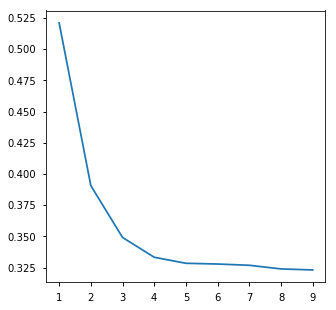

K with lowest cross validation MSE: 9
Lowest cross validation MSE 0.32308429224968743
CPU times: user 12min 35s, sys: 2.33 s, total: 12min 37s
Wall time: 12min 40s


In [68]:
%%time
from sklearn.neighbors import KNeighborsRegressor

neighbors = np.arange(1,10)
mse = []

for k in neighbors:
    knn = KNeighborsRegressor(n_neighbors = k, metric = 'mahalanobis', metric_params = {'V':X_train[knnvars].cov()})
    scores = cross_val_score(knn,X_train[knnvars],y_train,cv=10,scoring = 'neg_mean_squared_error')
    cv_mse = -1*np.mean(scores)
    mse.append(cv_mse)

fig, ax = plt.subplots(figsize = (5,5))
ax.plot(neighbors, mse)
plt.show()
print('K with lowest cross validation MSE: {}'.format(1 + np.argmin(mse)))
print('Lowest cross validation MSE {}'.format(min(mse)))

In [70]:
knn = KNeighborsRegressor(n_neighbors = 9, metric = 'mahalanobis', metric_params = {'V':X_train[knnvars].cov()})
knn.fit(X_train[knnvars],y_train)
pred_knn = knn.predict(X_test[knnvars])
mse_knn = mean_squared_error(pred_knn, y_test)
print('KNN Test MSE:', mse_knn)

KNN Test MSE: 0.318920900772


#### Ridge Regression

In [86]:
#See all variables
pd.set_option('display.max_columns',25)
X_train.head()

,Shops,ATMs,Downtown,Weekday,Center,High,ATMs_Center,Weekday_Center,Shops_2,Shops_Center,Downtown_Weekday,Shops_2_Center,Shops_3,Shops_ATMs_Downtown,Shops_Weekday_Center,ATMs_High,Shops_Downtown_High,ATMs_2_Weekday,Shops_ATMs_High,Shops_High
4900,9.66,10,1,1,0,0,0,0,93.3156,0.0,1,0.0,901.428696,96.60,0.0,0,0.00,100,0.00,0.00
20025,10.27,7,1,0,0,1,0,0,105.4729,0.0,0,0.0,1083.206683,71.89,0.0,7,10.27,0,71.89,10.27
1929,1.00,3,0,1,0,0,0,0,1.0000,0.0,0,0.0,1.000000,0.00,0.0,0,0.00,9,0.00,0.00
4901,9.83,9,1,1,0,0,0,0,96.6289,0.0,1,0.0,949.862087,88.47,0.0,0,0.00,81,0.00,0.00
9750,10.14,11,1,1,0,0,0,0,102.8196,0.0,1,0.0,1042.590744,111.54,0.0,0,0.00,121,0.00,0.00


In [183]:
#define standardise predictors 
mu = X_train.mean()
sigma = X_train.std()
def standardise(data):
    for i in data.loc[:,data.dtypes!='object']:
        if i!='Withdraw' and i!='Weekday'and i!='Downtown' and i!='High'and i!='Center' and i!= 'Downtown_Weekday' and i!= 'Weekday_Center':
            data[i] = (data[i]-mu[i])/(sigma[i])

In [184]:
standardise(X_train)
standardise(X_test)

In [123]:
#Fit Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

alphas = np.exp(np.linspace(-10,20,500)) 
ridge = RidgeCV(alphas=alphas, cv=5)
ridge.fit(X_train[x_int_sub], y_train)
ridge = Ridge(alpha=ridge.alpha_)
ridge.fit(X_train[x_int_sub], y_train)

Ridge(alpha=0.00041987601098775039, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [124]:
pred_ridge = ridge.predict(X_test[x_int_sub])
mse_ridge = mean_squared_error(pred_ridge,y_test)
print('Ridge Test MSE:',mse_ridge)

Ridge Test MSE: 0.248617615786


#### Lasso Regression

In [126]:
lasso = LassoCV(cv=5)
lasso.fit(X_train[x_int_sub],y_train)
pred_lasso = lasso.predict(X_test[x_int_sub])
mse_test_lasso = mean_squared_error(pred_lasso,y_test)
print('Lasso Test MSE', mse_test_lasso)

Lasso Test MSE 0.282805393294


#### Neural Networks

In [179]:
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(2)

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.callbacks import Callback, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV, ParameterGrid

nn_vars = ['Shops','ATMs','Downtown','Weekday','Center','High']

Number of columns used: 6


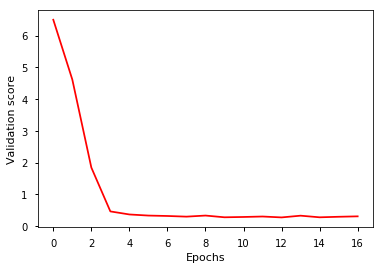

14560/15400 [===========================>..] - ETA: 0sDNN Validation MSE 0.304284430489
DNN Training MSE 0.295247339498


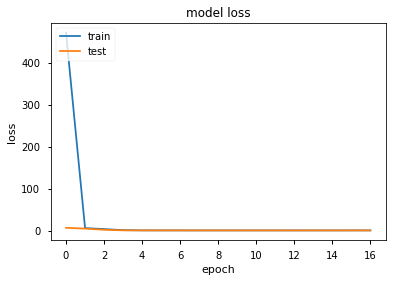

In [186]:
#Import keras libraries
from keras.callbacks import EarlyStopping

# Save the number of predictors in the dataset which will be used for the input: n_cols
n_cols = X_train[nn_vars].shape[1]
input_shape = (n_cols,)
print("Number of columns used:", n_cols)

# Specify the model
model = Sequential()
model.add(Dense(100, activation='relu', input_shape = input_shape))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='relu'))

# Compile the model
model.compile(optimizer = 'adam', loss = 'mse')

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience = 3)

# Fit the model
model_training = model.fit(np.array(X_train[nn_vars]), y_train, epochs = 30, validation_data = (np.array(X_test[nn_vars]), y_test), callbacks = [early_stopping_monitor], verbose = False)

# Create the plot & Print Results
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

mse = model.evaluate(np.array(X_test[nn_vars]), y_test)
mse_train = model.evaluate(np.array(X_train[nn_vars]), y_train)
print('DNN Validation MSE', mse)
print('DNN Training MSE', mse_train)

# summarize history for loss
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Grid Search

In [188]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers
from keras.callbacks import Callback, ModelCheckpoint
from keras.wrappers.scikit_learn import KerasRegressor

from sklearn.model_selection import GridSearchCV, ParameterGrid

activation1 = ['tanh', 'linear', 'selu', 'relu']
activation2 = ['tanh', 'linear', 'selu', 'relu']
activation3 = ['tanh', 'linear', 'selu', 'relu']
units = [10, 50, 100, 150]
optimizer = ['sgd','adagrad', 'adam', 'adamax']
epochs = 100
batch_size = 100

In [189]:
def create_model(units=10, activation1 = 'relu', activation2 = 'relu', activation3='relu'):
    model = Sequential()
    model.add(Dense(10, input_dim = 6, activation = activation1))
    model.add(Dense(10, activation = activation2))
    model.add(Dense(1, activation = activation3))
    model.compile(loss = 'mse', optimizer = 'adam')
    return(model)

In [190]:
model = KerasRegressor(build_fn=create_model, epochs=epochs, batch_size=batch_size, verbose=0)
X = np.array(X_train[nn_vars])
Y = y_train

param_grid = dict(activation1=activation1, activation2=activation2, activation3=activation3)
param_grid

{'activation1': ['tanh', 'linear', 'selu', 'relu'],
 'activation2': ['tanh', 'linear', 'selu', 'relu'],
 'activation3': ['tanh', 'linear', 'selu', 'relu']}

In [ ]:
#Takes very long time to run
from sklearn.metrics import mean_squared_error
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring = 'neg_mean_squared_error', cv=2,
                    n_jobs=1, refit=True, verbose=2)

grid_result = grid.fit(X, Y)

In [ ]:
#Print results, relu and 150 units are identified as best.
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

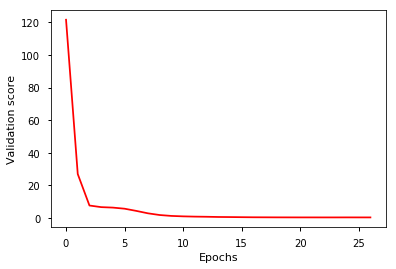

15360/15400 [============================>.] - ETA: 0sDNN Validation MSE 0.270654643304
DNN Training MSE 0.265331456003


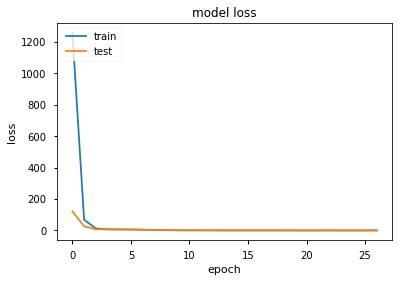

In [191]:
#Check model. MSE has 0.27
#Import keras libraries
from keras.callbacks import EarlyStopping

# Specify the bench mark model
model = Sequential()
model.add(Dense(150, input_dim = 6, activation = 'relu'))
model.add(Dense(1, activation = 'selu'))
model.compile(loss = 'mse', optimizer = 'adam')

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience = 3)

# Fit the model
model_training = model.fit(np.array(X_train[nn_vars]), y_train, epochs = 100, validation_data = (np.array(X_test[nn_vars]), y_test), callbacks = [early_stopping_monitor], verbose = False)

# Create the plot & Print Results
plt.plot(model_training.history['val_loss'], 'r')
plt.xlabel('Epochs')
plt.ylabel('Validation score')
plt.show()

mse = model.evaluate(np.array(X_test[nn_vars]), y_test)
mse_train = model.evaluate(np.array(X_train[nn_vars]), y_train)
print('DNN Validation MSE', mse)
print('DNN Training MSE', mse_train)

# summarize history for loss
plt.plot(model_training.history['loss'])
plt.plot(model_training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [133]:
%%time
np.random.seed(1000)
from keras.models import Sequential
from keras.layers import Dense
nn = Sequential()
nn.add(Dense(10, input_dim = 14, activation = 'selu'))
nn.add(Dense(10, activation = 'linear'))
nn.add(Dense(1, activation = 'linear'))


nn.compile(loss = 'mse', optimizer = 'AdaMax')
nn.fit(np.array(X_train[x_int_sub]), y_train, epochs = 200, batch_size =  100, shuffle = False)
mse_nn = nn.evaluate(np.array(X_test[x_int_sub]),y_test)
mse_nn2 = nn.evaluate(np.array(X_train[x_int_sub]),y_train)
print(' Neural Network MSE',mse_nn)
print(' Neural Network Train MSE',mse_nn2)

Epoch 1/200
15400/15400 [==============================] - 0s - loss: 2751.0516     
Epoch 2/200
15400/15400 [==============================] - 0s - loss: 513.8133     
Epoch 3/200
15400/15400 [==============================] - 0s - loss: 99.2436      
Epoch 4/200
15400/15400 [==============================] - 0s - loss: 63.4958     
Epoch 5/200
15400/15400 [==============================] - 0s - loss: 43.4276     
Epoch 6/200
15400/15400 [==============================] - 0s - loss: 29.2357     
Epoch 7/200
15400/15400 [==============================] - 0s - loss: 18.6553     
Epoch 8/200
15400/15400 [==============================] - 0s - loss: 10.8913     
Epoch 9/200
15400/15400 [==============================] - 0s - loss: 5.6828     
Epoch 10/200
15400/15400 [==============================] - 0s - loss: 2.7740     
Epoch 11/200
15400/15400 [==============================] - 0s - loss: 1.4781     
Epoch 12/200
15400/15400 [==============================] - 0s - loss: 0.9855     
E

15400/15400 [==============================] - 0s - loss: 0.2588     
Epoch 197/200
15400/15400 [==============================] - 0s - loss: 0.2588     
Epoch 198/200
15400/15400 [==============================] - 0s - loss: 0.2588     
Epoch 199/200
15400/15400 [==============================] - 0s - loss: 0.2588     
Epoch 200/200
14240/15400 [==========================>...] - ETA: 0s Neural Network MSE 0.256102587219
 Neural Network Train MSE 0.255764024544
CPU times: user 1min 35s, sys: 54.3 s, total: 2min 29s
Wall time: 1min 36s


In [134]:
%%time
np.random.seed(1000)
from keras.models import Sequential
from keras.layers import Dense
nn = Sequential()
nn.add(Dense(10, input_dim = 14, activation = 'selu'))
nn.add(Dense(10, activation = 'linear'))
nn.add(Dense(1, activation = 'linear'))


nn.compile(loss = 'mse', optimizer = 'adam')
nn.fit(np.array(X_train[x_int_sub]), y_train, epochs = 200, batch_size =  100,shuffle = False)
mse_nn = nn.evaluate(np.array(X_test[x_int_sub]),y_test)
mse_nn2 = nn.evaluate(np.array(X_train[x_int_sub]),y_train)
print(' Neural Network MSE',mse_nn)
print(' Neural Network Train MSE',mse_nn2)

Epoch 1/200
15400/15400 [==============================] - 1s - loss: 3051.5391     
Epoch 2/200
15400/15400 [==============================] - 0s - loss: 953.2178      
Epoch 3/200
15400/15400 [==============================] - 0s - loss: 158.0172     
Epoch 4/200
15400/15400 [==============================] - 0s - loss: 80.1034     
Epoch 5/200
15400/15400 [==============================] - 0s - loss: 52.0516     
Epoch 6/200
15400/15400 [==============================] - 0s - loss: 33.5698     
Epoch 7/200
15400/15400 [==============================] - 0s - loss: 20.0026     
Epoch 8/200
15400/15400 [==============================] - 0s - loss: 10.8066     
Epoch 9/200
15400/15400 [==============================] - 0s - loss: 5.5966     
Epoch 10/200
15400/15400 [==============================] - 0s - loss: 3.1815     
Epoch 11/200
15400/15400 [==============================] - 0s - loss: 2.2027     
Epoch 12/200
15400/15400 [==============================] - 0s - loss: 1.7806     


Epoch 196/200
15400/15400 [==============================] - 0s - loss: 0.2643     
Epoch 197/200
15400/15400 [==============================] - 0s - loss: 0.2643     
Epoch 198/200
15400/15400 [==============================] - 0s - loss: 0.2642     
Epoch 199/200
15400/15400 [==============================] - 0s - loss: 0.2642     
Epoch 200/200
14912/15400 [============================>.] - ETA: 0s Neural Network MSE 0.259213783597
 Neural Network Train MSE 0.259726972015
CPU times: user 1min 41s, sys: 1min 2s, total: 2min 43s
Wall time: 1min 45s


In [132]:
%%time
np.random.seed(1000)
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
nn = Sequential()
nn.add(Dense(10, input_dim = 14, activation = 'selu'))
nn.add(Dense(10, activation = 'linear'))
nn.add(Dense(1, activation = 'linear'))


nn.compile(loss = 'mse', optimizer = 'Nadam')
nn.fit(np.array(X_train[x_int_sub]), y_train, epochs = 200, batch_size =  100, shuffle = False)
mse_nn = nn.evaluate(np.array(X_test[x_int_sub]),y_test)
mse_nn2 = nn.evaluate(np.array(X_train[x_int_sub]),y_train)
print(' Neural Network MSE',mse_nn)
print(' Neural Network Train MSE',mse_nn2)

Epoch 1/200
15400/15400 [==============================] - 1s - loss: 2003.3835     
Epoch 2/200
15400/15400 [==============================] - 0s - loss: 119.3035     
Epoch 3/200
15400/15400 [==============================] - 0s - loss: 44.3708     
Epoch 4/200
15400/15400 [==============================] - 0s - loss: 18.0585     
Epoch 5/200
15400/15400 [==============================] - 0s - loss: 5.9372     
Epoch 6/200
15400/15400 [==============================] - 0s - loss: 2.3620     
Epoch 7/200
15400/15400 [==============================] - 0s - loss: 1.5639     
Epoch 8/200
15400/15400 [==============================] - 0s - loss: 1.2518     
Epoch 9/200
15400/15400 [==============================] - 0s - loss: 1.0363     
Epoch 10/200
15400/15400 [==============================] - 0s - loss: 0.8688     
Epoch 11/200
15400/15400 [==============================] - 0s - loss: 0.7359     
Epoch 12/200
15400/15400 [==============================] - 0s - loss: 0.6316     
Epoch 

15400/15400 [==============================] - 0s - loss: 0.2605     
Epoch 197/200
15400/15400 [==============================] - 0s - loss: 0.2605     
Epoch 198/200
15400/15400 [==============================] - 0s - loss: 0.2605     
Epoch 199/200
15400/15400 [==============================] - 0s - loss: 0.2605     
Epoch 200/200
14848/15400 [===========================>..] - ETA: 0s Neural Network MSE 0.252990069028
 Neural Network Train MSE 0.252947723045
CPU times: user 1min 54s, sys: 1min 21s, total: 3min 15s
Wall time: 2min


## Final Chosen Model

In [172]:
#Chosen model is regression with interaction terms as it yeilds the best results
X_train_final.head()

,Shops,ATMs,Downtown,Weekday,Center,High
4900,9.66,10,1,1,0,0
20025,10.27,7,1,0,0,1
1929,1.00,3,0,1,0,0
4901,9.83,9,1,1,0,0
9750,10.14,11,1,1,0,0


In [173]:
X_train_final['Weekday_Center'] = X_train_final['Weekday']*X_train_final['Center']
X_train_final['Shops_2'] = X_train_final['Shops']*X_train_final['Shops']
X_train_final['Shops_Center'] = X_train_final['Shops']*X_train_final['Center']
X_train_final['Downtown_Weekday'] = X_train_final['Downtown']*X_train_final['Weekday']
X_train_final['Shops_2_Center'] = X_train_final['Shops_2']*X_train_final['Center']
X_train_final['Shops_3'] = X_train_final['Shops']*X_train_final['Shops_2']
X_train_final['Shops_ATMs_Downtown'] = X_train_final['Shops']*X_train_final['ATMs']*X_train_final['Downtown']
X_train_final['Shops_Weekday_Center'] = X_train_final['Shops_Center']*X_train_final['Weekday']

In [174]:
X_train_final.head()

,Shops,ATMs,Downtown,Weekday,Center,High,Weekday_Center,Shops_2,Shops_Center,Downtown_Weekday,Shops_2_Center,Shops_3,Shops_ATMs_Downtown,Shops_Weekday_Center
4900,9.66,10,1,1,0,0,0,93.3156,0.0,1,0.0,901.428696,96.60,0.0
20025,10.27,7,1,0,0,1,0,105.4729,0.0,0,0.0,1083.206683,71.89,0.0
1929,1.00,3,0,1,0,0,0,1.0000,0.0,0,0.0,1.000000,0.00,0.0
4901,9.83,9,1,1,0,0,0,96.6289,0.0,1,0.0,949.862087,88.47,0.0
9750,10.14,11,1,1,0,0,0,102.8196,0.0,1,0.0,1042.590744,111.54,0.0


In [175]:
x_int_sub_final = ['Shops','ATMs','Weekday','Downtown','Center','High','Shops_2','Shops_Center','Downtown_Weekday',
         'Shops_2_Center','Shops_3','Weekday_Center','Shops_ATMs_Downtown','Shops_Weekday_Center']

In [177]:
import pickle
from sklearn.linear_model import LinearRegression
ols = LinearRegression()
final = ols.fit(X_train_final[x_int_sub_final],y_train)
pickle.dump(final, open('my_model.h5', 'wb'))